In [1]:
import numpy as np
import os
import io
import cv2
import glob
import tensorflow as tf
import tensorflow_datasets as tfds
from densenet import densenet_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

tf.__version__

'2.2.0'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
print(tf.config.experimental.list_logical_devices('GPU'))
tf.test.is_gpu_available()


1 Physical GPUs, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
# hyperparameters
# data
rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2
horizontal_flip = True
vertical_flip = True
shear_range = 0
zoom_range = 0.5
size = (32,32)

# model
nb_filter = 64
growth_rate = 64
nb_layers = [6, 12, 16]
reduction = 0.5

# training
lr = 0.001
epochs = 100
max_patience = 100
batch_size = 256
train_epochs = 3

# log
log_freq = 1
models_directory = 'results/models/'
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
identifier = "{}-growth-{}-densenet".format(
    '-'.join([str(i) for i in nb_layers]),
    growth_rate) + date

In [4]:
# Construct a tf.data.Dataset
ds_train = tfds.load('cifar100', split='train', shuffle_files=True, batch_size=-1)
train_np_ds = tfds.as_numpy(ds_train)
ds_test = tfds.load('cifar100', split='test', shuffle_files=False, batch_size=-1)
test_np_ds = tfds.as_numpy(ds_test)

x_train, y_train = train_np_ds["image"], train_np_ds["label"]
x_test, y_test = test_np_ds["image"], test_np_ds["label"]

# shuffle the meta train images maintaining the same label order
index_sets = [np.argwhere(i==y_train) for i in np.unique(y_train)]
x_meta_train = np.copy(x_train)
for class_indexes in index_sets:
    shuffled_class_indexes = np.copy(class_indexes)
    np.random.shuffle(shuffled_class_indexes)
    for i in range(len(class_indexes)):
        x_meta_train[class_indexes[i]] = x_train[shuffled_class_indexes[i]]

classes = np.unique(y_train)

train_size = x_train.shape[0]
test_size = x_test.shape[0]

info = tfds.builder('cifar100').info
n_classes = info.features['label'].num_classes
img_shape = info.features['image'].shape

In [5]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    horizontal_flip=horizontal_flip,
    vertical_flip = vertical_flip,
    shear_range=shear_range,
    zoom_range=zoom_range,
    fill_mode='constant',
    cval=0,
)

datagen.fit(x_train)

test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

test_datagen.fit(x_train)

# create data generators
train_gen =  datagen.flow(x_train, y_train, batch_size=batch_size, seed=42)
meta_train_gen =  datagen.flow(x_meta_train, y_train, batch_size=batch_size, seed=42)
test_gen = test_datagen.flow(x_test, y_test , batch_size=batch_size, shuffle=False)

In [6]:
all_labels = []
batches = 0
for images, labels in train_gen:
    batches += 1
    all_labels = np.append(all_labels, labels)    
    if batches >= train_size / batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
all_meta_labels = []
batches = 0
for images, labels in meta_train_gen:
    batches += 1
    all_meta_labels = np.append(all_meta_labels, labels)    
    if batches >= train_size / batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
print(all_labels == all_meta_labels)

[ True  True  True ...  True  True  True]


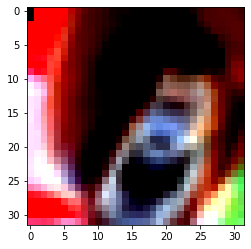

In [7]:
for images, labels in train_gen:
    plt.imshow(images[0])
    break

In [8]:
model = densenet_model(classes=n_classes, nb_filter=nb_filter, shape=img_shape, growth_rate=growth_rate, nb_layers=nb_layers, reduction=reduction)

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
meta_optimizer = tf.keras.optimizers.Adam()

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [11]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(tf.cast(images, tf.float32), training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

    return predictions


@tf.function
def meta_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(tf.cast(images, tf.float32), training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    return gradients

@tf.function
def test_step(images, labels):
    predictions = model(tf.cast(images, tf.float32), training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [12]:
# create summary writers
train_summary_writer = tf.summary.create_file_writer('results/summaries/train/' + identifier)
test_summary_writer = tf.summary.create_file_writer('results/summaries/test/' + identifier)

min_loss = 100
min_loss_acc = 0
patience = 0

In [13]:
print("starting training")
time_record = ''
for epoch in range(epochs):
    time_start = time.time()

    for train_epoch in range(train_epochs):
        print("train epoch: " + str(train_epoch))
        batches = 0
        while batches < train_size / batch_size:

            batches += 1

            # get the weights of the initial model that will do the meta learning
            meta_model_weights = model.get_weights()

            # train on the task (one batch)
            images, labels = train_gen.next()
            train_step(images, labels)

            # test on the validation set the improvement achieved on one task for the meta learning
            images, labels = meta_train_gen.next()
            gradients = meta_step(images, labels)

            # set weights of the model to the weights of the original model
            model.set_weights(meta_model_weights)                        

            # update the weights of the meta learning model using the loss obtained from testing
            meta_optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # get the weights of the initial model that will do the meta learning
    meta_model_weights = model.get_weights()

    # train on the task (one epoch)
    batches = 0
    for images, labels in train_gen:
        batches += 1
        train_step(images, labels)
        if batches >= train_size / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

    # test the newly trained model on the training set
    batches = 0
    for test_images, test_labels in test_gen:
        test_step(test_images, test_labels)
        batches += 1
        if batches >= test_size / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    
    # set weights of the model to the weights of the original model
    model.set_weights(meta_model_weights)                        

    time_finish = time.time()
    end_time = (time_finish-time_start)
    time_record = time_record + '{:.3f} s \n'.format(end_time)

    if (epoch % log_freq == 0):
        print ('Epoch: {}, Train Loss: {}, Train Acc:{}, Test Loss: {}, Test Acc: {}, Time: {} s'.format(
               epoch,
               train_loss.result(),
               train_accuracy.result()*100,
               test_loss.result(),
               test_accuracy.result()*100,
               end_time))

        if (test_loss.result() < min_loss):    
            if not os.path.exists(models_directory):
                os.makedirs(models_directory)
            # serialize weights to HDF5
            model.save_weights(models_directory + "best{}.h5".format(identifier))
            min_loss = test_loss.result()
            min_loss_acc = test_accuracy.result()
            patience = 0
        else:
            patience += 1

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
            train_loss.reset_states()           
            train_accuracy.reset_states()           

        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
            test_loss.reset_states()           
            test_accuracy.reset_states()   

    if patience >= max_patience:
        break

with open(os.path.join('results/', identifier), "w") as file1:
    file1.write(time_record)

starting training
train epoch: 0
train epoch: 1
train epoch: 2
Epoch: 0, Train Loss: 4.791623592376709, Train Acc:9.314499855041504, Test Loss: 3.6917662620544434, Test Acc: 13.809999465942383, Time: 362.89227175712585 s
train epoch: 0
train epoch: 1
train epoch: 2
Epoch: 1, Train Loss: 3.9383606910705566, Train Acc:17.04450035095215, Test Loss: 3.4201340675354004, Test Acc: 18.15999984741211, Time: 335.12327241897583 s
train epoch: 0
train epoch: 1
train epoch: 2
Epoch: 2, Train Loss: 3.348360538482666, Train Acc:24.04199981689453, Test Loss: 3.2014572620391846, Test Acc: 22.90999984741211, Time: 334.28536462783813 s
train epoch: 0
train epoch: 1
train epoch: 2
Epoch: 3, Train Loss: 3.1191158294677734, Train Acc:28.519498825073242, Test Loss: 3.2106246948242188, Test Acc: 21.989999771118164, Time: 333.8260567188263 s
train epoch: 0
train epoch: 1
train epoch: 2
Epoch: 4, Train Loss: 2.8037197589874268, Train Acc:33.75299835205078, Test Loss: 3.192918539047241, Test Acc: 22.11000061035

train epoch: 1
train epoch: 2
Epoch: 41, Train Loss: 0.3884947597980499, Train Acc:89.989501953125, Test Loss: 7.189992427825928, Test Acc: 23.059999465942383, Time: 333.294397354126 s
train epoch: 0
train epoch: 1
train epoch: 2
Epoch: 42, Train Loss: 0.1872801035642624, Train Acc:94.322998046875, Test Loss: 7.343153476715088, Test Acc: 23.729999542236328, Time: 333.7393891811371 s
train epoch: 0
train epoch: 1
train epoch: 2
Epoch: 43, Train Loss: 0.3505728542804718, Train Acc:90.3115005493164, Test Loss: 6.283110618591309, Test Acc: 23.309999465942383, Time: 333.7105498313904 s
train epoch: 0
train epoch: 1
train epoch: 2
Epoch: 44, Train Loss: 0.1854812502861023, Train Acc:94.43099975585938, Test Loss: 7.277207851409912, Test Acc: 23.5, Time: 333.0819134712219 s
train epoch: 0
train epoch: 1
train epoch: 2
Epoch: 45, Train Loss: 0.17867028713226318, Train Acc:94.61600494384766, Test Loss: 7.184941291809082, Test Acc: 23.489999771118164, Time: 333.515771150589 s
train epoch: 0
train

train epoch: 1
train epoch: 2
Epoch: 82, Train Loss: 0.1040768101811409, Train Acc:96.82550048828125, Test Loss: 8.20551872253418, Test Acc: 23.610000610351562, Time: 333.77868485450745 s
train epoch: 0
train epoch: 1
train epoch: 2


KeyboardInterrupt: 